# Random Transit Network Algorithm
### TR-GY 7133: Urban Public Transport, Assignment 2
<b>Matthew Urbanek</b><br>
New York University Center for Urban Science and Progress

## Part 1: Define parameters and methods
### Part 1a) Given values from assignment

In [1]:
veh_speed = 20 # miles per hour
dwell = 1 # minutes
vW = 2.4 # miles per hour
vcap = 60 # seats
value_of_time = 0.33 # dollar per minute, for fare-time conversion
demand_coef = 2500 # for demand function

### Part 1b) My parameter values
Note the choices for betaA, betaW, and betaF.  They are negative because demand should decrease as the respective variables increases.  And the relative size compared to -0.3 (betaT) is based on Ceder, elasticity coefficients for various stages of travel.  "Access time" is the highest cost, followed by waiting time, then in-vehicle travel time.  betaF is based on typical transit-demand price elasticity in urban areas. 

In [2]:
fare = 2.5 # typical public-transit system flat fare
betaA, betaW, betaF = -0.9, -0.5, -0.3
walk_coef,wait_coef,ttime_coef = 3, 1.8, 1
default_hw = 30 # starting headway (minutes) for first iteration of demand generation
rseed = 119 # my favorite number

### Part 1c) Functions
Beginning with various Python open source libraries

In [3]:
import numpy as np
np.random.seed(rseed)
import pandas as pd
import operator
import math
from scipy.spatial import distance
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import networkx as nx
import random
random.seed(rseed)
%pylab inline
%matplotlib inline
plt.rcParams["figure.figsize"]=(10.0,10.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<b>best_double</b> determines the lowest-cost way to link an unconnected node to an existing network in order to satisfy an O&D. It takes as an argument a "new link penalty," which is multiplied by the distance of any new links used to form the new path.

In [4]:
def best_double(g,orig_node,dest_node,penalty=10):
    newnet = nx.DiGraph()
    newnet.add_edges_from(g.edges(data=True))
    for e in nx.non_edges(g):
        newnet.add_edge(e[0],e[1])
        newnet[e[0]][e[1]]['dist'] = dm[e]*penalty
    return nx.shortest_path(newnet,source=orig_node,target=dest_node,weight='dist')

<b>label_new_routes</b> creates routing strings from unrouted links.  The logic works as follows: for each unrouted link, check if it can be added to the terminus of an existing route.  Only designate a new route if an existing route cannot be extended.

In [5]:
def label_new_routes(path,r):   
    # start backward propogation
    for i in np.arange(len(path)-1):
        if rnw[path[-2-i]][path[-1-i]]['route'] == -1: # if link is labeled
            # check if dest is an origin of any route
            if rnw.node[path[-1-i]]['route_start'] == -1:
                # then it's not connected
                pass
            else:
                # set it to be the new route start
                route_name = rnw[path[-1-i]]['route_start']
                rnw[path[-2-i]][path[-1-i]]['route'] = route_name
                rnw.node[path[-2-i]]['route_start'] = route_name
                rnw.node[path[-1-i]]['route_start'] = -1
        else:
            pass
    # start forward propogation
    last_act = ''
    r += 1
    for i in np.arange(len(path)-1):
        if rnw[path[i]][path[i+1]]['route'] == -1: # if link is unlabeled
            # check if orig is the terminal of any route
            if rnw.node[path[i]]['route_end'] == -1:
                # then it's not connected, so we should designate this with a new route number
                rnw[path[i]][path[i+1]]['route'] = r
                last_act = 'n' # remember that the resulting action on this link was to designate a new route
            else: # case that there is a route extension possible
                if last_act == 'n':
                    r += 1 # increment the route number if we're done extending an existing route
                route_name = rnw.node[path[i]]['route_end']
                rnw[path[i]][path[i+1]]['route'] = route_name
                rnw.node[path[i]]['route_end'] = -1
                rnw.node[path[i+1]]['route_end'] = route_name
                last_act = 'e'
        else: # case that there is a label already
            if last_act == 'n':
                r += 1
            last_act = 'a'
    return r

<b>path_metrics</b> returns the travel time, number of transfers, and estimated wait time for a given transit-path.  Wait time estimation is hardcoded as 0.5 * headway.

In [6]:
def path_metrics(path):
    ttime = 0
    xfers = 0
    wtime = 0
    for i in np.arange(len(path)-1):
        ttime += rnw[path[i]][path[i+1]]['time']
        # print rnw[path[i]][path[i+1]]['route']
        if i==0:
            wtime += 0.5*hw[rnw[path[i]][path[i+1]]['route']]
        else:
            if last_route == rnw[path[i]][path[i+1]]['route']:
                xfers += 0
                wtime += 0
            else:
                xfers += 1
                wtime += 0.5*hw[rnw[path[i]][path[i+1]]['route']]
        last_route = rnw[path[i]][path[i+1]]['route']
    return ttime, xfers, wtime

<b>od_demand</b> returns the demand, access time and transit-path metrics for a given O&D.  Note that not all O&Ds require walking to access the transit node.  1 minute is added to access time to ensure non-zero values in those cases.

In [7]:
fare_time = fare/value_of_time
def od_demand(od,betaA=betaA,betaW=betaW,fare_time=fare_time,betaF=betaF,demand_coef=demand_coef):
    ttime, xfers, wtime = path_metrics(all_od_paths[od])
    # then need to calc atime
    # get dist to start node
    # convert to walk minutes
    walk_dist = 0
    walk_dist += distance.euclidean(ClusPos[all_od_paths[od][0]],all_nodes[od[0]])
    walk_dist += distance.euclidean(ClusPos[all_od_paths[od][-1]],all_nodes[od[1]])
    atime = 1 + (60 * walk_dist / vW)
    try:
        Q = demand_coef * (atime**betaA) * (wtime**betaW) * (ttime**-0.3) * (fare_time**betaF)
    except:
        Q = 0
    return Q, atime, ttime, xfers, wtime
# betaA < betaW < betaT based on utility

<b>flow_edges</b> returns a table of flows on each link for a given O&D and path.

In [8]:
def flow_edges(od,g):
    d = od_demand(od)[0]
    demands = pd.DataFrame(columns=['od','path','edge','route','demand'])
    routes = nx.get_edge_attributes(g,'route')
    path = all_od_paths[od]
    for i in np.arange(len(path)-1):
        demands = demands.append({'od':od,'path':path,'edge':(path[i],path[i+1]),'route':routes[(path[i],path[i+1])],'demand':d},ignore_index=True)
    return demands

<b>calc_freq</b> returns a target hourly frequency (rounded up to integers) given some demand and vehicle capacity.  This will get applied to the hourly demand at the maximum load point for each route.

In [9]:
def calc_freq(demand,vcap=vcap):    
    freq_float = np.divide(demand,vcap)
    return math.ceil(freq_float)

<b>connectivity</b> returns the aggregated connectivity metric across all paths.  In this case it is calculating O&D people-access-connectivity as:<br>
$$\begin{equation}
{C_D^F}_k = \sum_p {c_p^F}
\end{equation}$$
<br>where<br>
$$\begin{equation}
{c_p^F} = c_p f_p
\end{equation}$$<br>
with ${f_p}$ as the flow on each path and ${c_p}$ as the path connectivity metric.  Path connectivity uses walking time, waiting time, and travel time values and coefficients.  In this model, variances are assumed to be zero and are not included.

In [10]:
def connectivity(all_paths,walk_coef,wait_coef,ttime_coef):
    c = 0
    for od,path in all_od_paths.iteritems():
        Q, atime, ttime, xfers, wtime = od_demand(od)
        c += Q*walk_coef*atime*ttime_coef*ttime*wait_coef*wtime
    return c

<b>network_objectives</b> returns values for two objective functions, Z1 "passenger disutility / empty seats" and "fleet size," given a network and its flow.  Z1 is defined in lecture materials as aggregated passenger wait time and travel time + total empty "seat-time."  Fleet size is determined using the route running time plus an assumed 10-minute layover, and routed up to the next integer for each route. (In other words, no deadheading assumed).

In [11]:
def network_objectives(g,all_od_paths,flow):
    # itialize objective values as zero
    layover = 10
    Z1 = 0
    fleet_size = 0
    route_ttime = 0
    route_subindex = ''
    for od,path in all_od_paths.iteritems():
        ttime, xfers, wtime = path_metrics(path)
        Z1 += (ttime+wtime) * od_demand(od)[0]
    times = nx.get_edge_attributes(g,'time')
    for index, row in flow.groupby(['route','edge']).sum().iterrows():
        freq = 60/hw[index[0]]
        if index[0]==route_subindex:
            fleet_size += math.ceil((route_ttime + layover) * freq / 60)
            # then reset route counter
            route_ttime = 0
        else:
            route_ttime += times[index[1]]
        empty_seats = vcap*freq - row.sum()
        Z1 += empty_seats * times[index[1]]
        route_subindex = index[0]
    return Z1, fleet_size

## Part 2: Generate random ODs and cluster ends into stop locations
#### Part 2a) Create x,y coordinates for orig and dest nodes randomly between 0 and 10

In [12]:
all_nodes = 10*np.random.uniform(size=(40,2))
all_ods = pd.DataFrame(data=all_nodes.reshape((20,4)),columns=['orig_x','orig_y','dest_x','dest_y'])
all_ods.index = pd.MultiIndex.from_tuples(list(zip(*(np.reshape(np.arange(40),(2,20))))),names=['orig','dest'])
all_ods

,,orig_x,orig_y,dest_x,dest_y
orig,dest,,,,
0,20,8.478438,4.978312,2.040477,7.522716
1,21,6.308315,0.569252,0.427689,4.199865
2,22,9.870615,0.903170,1.220985,5.397358
3,23,7.929445,3.859168,3.275442,0.433439
4,24,3.385719,5.431645,5.528358,7.170738
5,25,5.642256,5.989717,7.877096,8.641504
6,26,8.048819,2.642067,5.786225,1.358843
7,27,5.751451,0.427087,8.138747,2.862139
8,28,9.469014,8.259550,0.422488,3.945721


#### Part 2b) Cluster nodes within 0.5 miles of each other
This calls a clustering algorithm called DBSCAN (Density-based spatial clustering of applications with noise).
<br>
<a href='https://en.wikipedia.org/wiki/DBSCAN'>https://en.wikipedia.org/wiki/DBSCAN</a>
<br>
Documentation for Python implementation:<br>
<a href='http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html'>http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html</a>
<br>
Ester, M., H. P. Kriegel, J. Sander, and X. Xu, “A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise”. In: Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226-231. 1996

In [13]:
db = DBSCAN(eps=0.5,min_samples=2)
db.fit(all_nodes)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    min_samples=2, p=None, random_state=None)

... and map the cluster indexes to the OD nodes

In [14]:
node_df = pd.DataFrame(all_nodes,columns=['x','y'])
node_df['clus'] = db.labels_
c = max(node_df['clus']) + 1
for index, row in node_df.iterrows():
    if row['clus']<0:
        node_df.loc[index,'clus'] = c
        c += 1
all_clus = np.asarray(node_df.groupby('clus').mean())

In [15]:
print 'Total number of clusters (stops): ' + str(len(all_clus))

Total number of clusters (stops): 32


#### Visualization of OD pairs with stop locations:

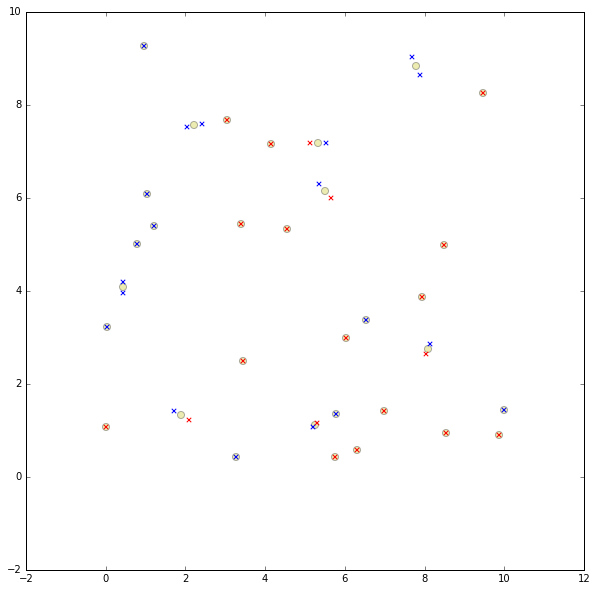

In [16]:
plt.scatter(all_clus[:,0],all_clus[:,1],c='y',s=50,alpha=0.3)
plt.scatter(all_ods.orig_x,all_ods.orig_y,c='r',marker='x')
plt.scatter(all_ods.dest_x,all_ods.dest_y,c='b',marker='x')

#### Part 2c) Make a list of OD pairs using the cluster ids, not the original node ids

In [17]:
clus_ods = []
for tup in all_ods.index.values:
    clus_ods = clus_ods + [(int(node_df.loc[tup[0],'clus']),int(node_df.loc[tup[1],'clus']))]
print clus_ods

[(8, 20), (0, 21), (9, 22), (1, 3), (10, 6), (11, 7), (12, 23), (13, 0), (14, 7), (2, 24), (3, 25), (4, 4), (5, 2), (15, 26), (16, 27), (5, 6), (17, 28), (1, 29), (18, 30), (19, 31)]


#### Part 2d) Store a distance matrix for the clusters
(Makes future calculation simpler)

In [18]:
dm = distance.squareform(distance.pdist(all_clus,'euclidean'))

## Part 3: Create a sparse "template" network
This is proposed in order to address algorithm complexity
These are not the edges of the actual route network, but instead a set of edges to which  first paths must use

#### Part 3a) Start with "stars" i.e. edges between nearby nodes only

In [19]:
neigh = NearestNeighbors(2, 0.4)
neigh.fit(all_clus)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=2, p=2, radius=0.4)

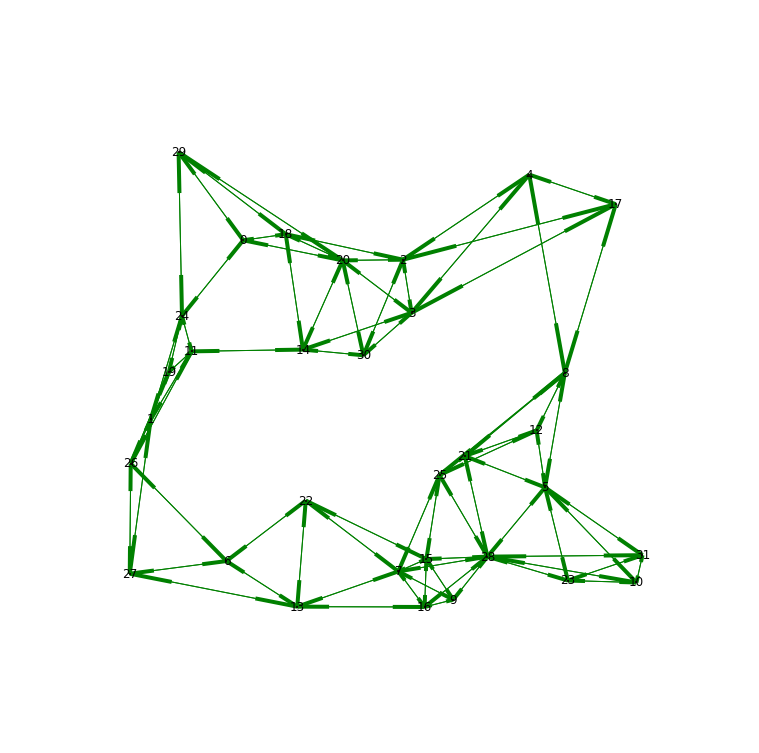

In [20]:
ClusPos={}
nearby_links = []
i = 0
for clus in all_clus:
    nb = neigh.kneighbors(clus.reshape(1, -1), 5, return_distance=True)
    ClusPos[i]=(clus[0],clus[1])
    nearby_links = nearby_links + zip([i,i,i,i],list(nb[1][0][1:]),list(nb[0][0][1:]))
    i += 1
clus_index = [c for c in np.arange(len(all_clus))]
nw = nx.Graph()
nw.add_nodes_from(clus_index)
nw.add_weighted_edges_from(nearby_links,weight='dist')
nw = nw.to_directed()
nx.draw(nw,pos=ClusPos,with_labels=True,arrows=True,node_size=1,width=1,edge_color='green')

#### Part 3b) Add edges for the ODs themselves, if they weren't generated in the previous step
So that every OD path has a nonstop path option 

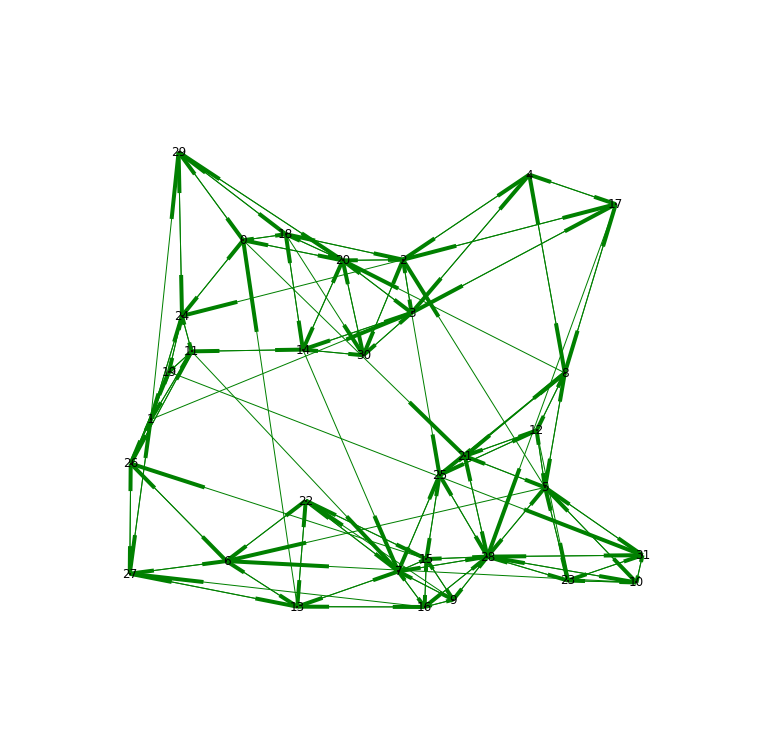

In [21]:
nw.add_edges_from(clus_ods)
# also recalculate distance and time weights for each existing edge
def calc_weights(g,dm=dm,dwell=dwell,veh_speed=veh_speed):
    for e in g.edges():
        g[e[0]][e[1]]['dist'] = dm[e]
        g[e[0]][e[1]]['time'] = dwell+60*dm[e]/veh_speed
    return g
nw = calc_weights(nw)
nx.draw(nw,pos=ClusPos,with_labels=True,arrows=True,node_size=1,width=1,edge_color='green')

## Part 4: Add edges from the "template" network until all ODs have a path
### Part 4a) Start with some random paths between perimeter nodes
This should coerce the first paths to be longer, diametrical paths

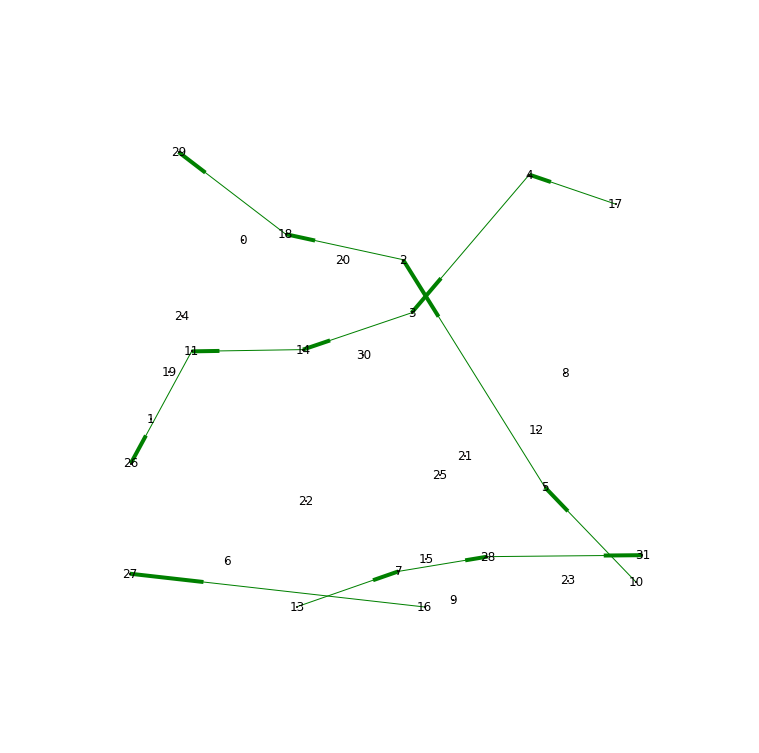

In [22]:
hull = ConvexHull(all_clus)
# list separately the cluster ids mapped to origin nodes and to destination nodes
orig_clus = node_df[:20]['clus'].unique()
dest_clus = node_df[20:]['clus'].unique()
hull_origs = list(set(orig_clus).intersection(hull.vertices))
hull_dests = list(set(dest_clus).intersection(hull.vertices))
# randomize
random.shuffle(hull_origs)
random.shuffle(hull_dests)
# create a new network for the new paths
rnw = nx.DiGraph()
rnw.add_nodes_from(clus_index)
for e in zip(hull_origs,hull_dests):
    spath = nx.shortest_path(nw,e[0],e[1],'dist')    
    rnw.add_path(spath) 
# calculate distance and time weights for each existing edge
rnw = calc_weights(rnw)
nx.draw(rnw,pos=ClusPos,with_labels=True,arrows=True,node_size=1,width=1,edge_color='green')

### Part 4b) Iterate randomly through the list of ODs and add remaining necessary edges

Best new path is identified by minimizing a cost function with terms legnth of existing edges and ledght of added edges, with a coefficient to account for the cost of "building new track"

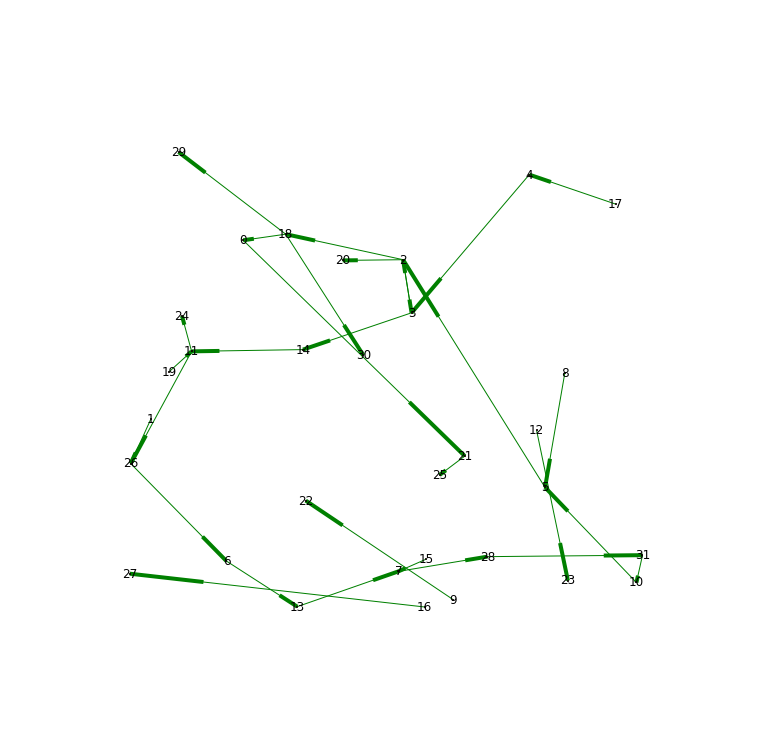

In [23]:
random_ods = all_ods.index.values
random.shuffle(random_ods)
for od in random_ods:
    try:
        # check if there is any valid path yet
        pathcheck = nx.has_path(rnw,node_df.loc[od[0],'clus'],node_df.loc[od[1],'clus'])
        if pathcheck is False:
            # find the best new path and add edges
            newpath = best_double(rnw,node_df.loc[od[0],'clus'],node_df.loc[od[1],'clus'],penalty=10)
            rnw.add_path(newpath)
        else:
            # go to the next od
            continue
    except:
        print 'error adding from od: '
        print od
# Calculate distance and time weights for new edges
rnw = calc_weights(rnw)
nx.draw(rnw,pos=ClusPos,with_labels=True,arrows=True,node_size=1,width=1,edge_color='green')

## Part 5: Route the network

In [24]:
# first, drop any existing route labels
nx.set_edge_attributes(rnw,'route',-1)

### Part 5a) Determine the shortest path (in distance and number of edges) for each OD

In [25]:
all_od_paths = {}
for od in all_ods.index.values:
    all_od_paths[od] = nx.shortest_path(rnw,node_df.loc[od[0],'clus'],node_df.loc[od[1],'clus'],weight='dist')
lengths = {}
for k,v in all_od_paths.iteritems():
    lengths[k] = len(v)

### Part 5b) Sort the paths in descending order of length, and create routes for each if needed

In [26]:
sorted_paths = sorted(lengths.items(), key=operator.itemgetter(1),reverse=True)
# itiatialize first on longest route
r = 0
nx.set_node_attributes(rnw,'route_start',-1)
nx.set_node_attributes(rnw,'route_end',-1)
# use the longest path as the first
path = all_od_paths[sorted_paths[0][0]]
for i in np.arange(len(path)-1):
    rnw[path[i]][path[i+1]]['route'] = r
rnw.node[path[0]]['route_start'] = r
rnw.node[path[-1]]['route_end'] = r
# then for each subsequent path, add create new routes from any sequences of unmarked edges
for path in sorted_paths[1:]:
    r = label_new_routes(all_od_paths[path[0]],r)

## Part 6: Generate headways and flows

In [27]:
# Initiate using default headway
hw = {}
for e in rnw.edges(data=True):
    hw[e[2]['route']] = default_hw

Note: Because of randomness in OD coordinates, it is possible for there to be an OD pair that is walking-only (no network edge used). This specific random set has one such OD pair (11,31):

In [28]:
ttime, xfers, wtime = path_metrics(all_od_paths[(11,31)])
print 'In-Vehicle Travel Time: ' + str(ttime)
print 'Wait Time: ' + str(wtime)

In-Vehicle Travel Time: 0
Wait Time: 0


### Part 6a) Generate flows from demand and recalculate headway based on hourly maximum load point.  Iterate four times.

In [29]:
for i in range(4):
    flow = pd.DataFrame(columns=['od','path','edge','route','demand'])
    for od,path in all_od_paths.iteritems():
        flow = flow.append(flow_edges(od,rnw),ignore_index=True)
    tot_demands = flow.groupby(['route','edge']).sum()
    new_hw = np.divide(60,tot_demands.groupby(level=0).max().apply(calc_freq,axis=1))
    hw = new_hw

## Part 7: Report final metrics

#### List of routes and final calculated headways (minutes)

In [30]:
hw

route
0      8.571429
1     30.000000
2      8.571429
4     30.000000
6     60.000000
7     30.000000
11    60.000000
12    60.000000
14    60.000000
16    30.000000
17    30.000000
20    12.000000
21    15.000000
22    12.000000
23    15.000000
dtype: float64

#### List of ODs with resulting demand and number of edges used

In [31]:
flow.groupby(['od','demand']).size()

od        demand    
(0, 20)   84.733121      3
(1, 21)   21.543958      1
(2, 22)   239.837965     1
(3, 23)   16.817983     10
(4, 24)   20.889315      7
(5, 25)   70.621601      4
(6, 26)   279.117875     1
(7, 27)   14.071677      8
(8, 28)   66.125894      5
(9, 29)   18.490076      4
(10, 30)  8.976995       5
(12, 32)  39.643776      1
(13, 33)  60.077506     10
(14, 34)  207.869305     1
(15, 35)  15.462325      6
(16, 36)  78.429853      9
(17, 37)  47.560017     11
(18, 38)  283.937860     1
(19, 39)  86.913031      7
dtype: int64

#### Connectivity and design objective metrics

In [32]:
print 'OD-people-access connectivity: ' + str(int(connectivity(all_od_paths,walk_coef,wait_coef,ttime_coef)))

OD-people-access connectivity: 8477511


In [33]:
objs = network_objectives(rnw,all_od_paths,flow)
print 'Design objective 1 (passenger disutility and empty-seat-time): ' + str(int(objs[0]))
print 'Design objective 2 (fleet size): ' + str(int(objs[1]))

Design objective 1 (passenger disutility and empty-seat-time): 88803
Design objective 2 (fleet size): 28


# Part 8: Disturb demand model and compare before-after

In [34]:
# update certain parameter values
demand_coef = 5000
veh_speed = 15

#### Part 8a) Reinitialize demand function to store updated parameter values

In [35]:
def od_demand(od,betaA=betaA,betaW=betaW,fare_time=fare_time,betaF=betaF,demand_coef=demand_coef):
    ttime, xfers, wtime = path_metrics(all_od_paths[od])
    # then need to calc atime
    # get dist to start node
    # convert to walk minutes
    walk_dist = 0
    walk_dist += distance.euclidean(ClusPos[all_od_paths[od][0]],all_nodes[od[0]])
    walk_dist += distance.euclidean(ClusPos[all_od_paths[od][-1]],all_nodes[od[1]])
    atime = 1 + (60 * walk_dist / vW)
    try:
        Q = demand_coef * (atime**betaA) * (wtime**betaW) * (ttime**-0.3) * (fare_time**betaF)
    except:
        Q = 0
    return Q, atime, ttime, xfers, wtime
# betaA < betaW < betaT based on utility

#### Part 8b) Recalculate people-access connectivity from new flows and travel times

In [36]:
# first recalculate travel times for each edge.  Wait times will not change because we haven't changed headway yet.
rnw = calc_weights(rnw)

In [37]:
new_flow = pd.DataFrame(columns=['od','path','edge','route','demand'])
for od,path in all_od_paths.iteritems():
     new_flow = new_flow.append(flow_edges(od,rnw),ignore_index=True)
tot_demands = new_flow.groupby(['route','edge']).sum()
new_hw = np.divide(60,tot_demands.groupby(level=0).max().apply(calc_freq,axis=1))

#### Part 8c) Report metrics given new demand coefficient and vehicle speed but BEFORE adjusting headway

In [38]:
print 'OD-people-access connectivity: ' + str(int(connectivity(all_od_paths,walk_coef,wait_coef,ttime_coef)))

OD-people-access connectivity: 16955022


In [39]:
objs = network_objectives(rnw,all_od_paths,flow)
print 'Design objective 1 (passenger disutility and empty-seat-time): ' + str(int(objs[0]))
print 'Design objective 2 (fleet size): ' + str(int(objs[1]))

Design objective 1 (passenger disutility and empty-seat-time): 153806
Design objective 2 (fleet size): 28


#### Part 8d) Reset headways to default and recalculate, given the new demands

In [40]:
hw = {}
for e in rnw.edges(data=True):
    hw[e[2]['route']] = default_hw
for i in range(4):
    new_flow = pd.DataFrame(columns=['od','path','edge','route','demand'])
    for od,path in all_od_paths.iteritems():
        new_flow = new_flow.append(flow_edges(od,rnw),ignore_index=True)
    tot_demands = new_flow.groupby(['route','edge']).sum()
    new_hw = np.divide(60,tot_demands.groupby(level=0).max().apply(calc_freq,axis=1))
    hw = new_hw

#### Part 8e) Report metrics AFTER new headways have been adjusted.

In [41]:
print 'OD-people-access connectivity: ' + str(int(connectivity(all_od_paths,walk_coef,wait_coef,ttime_coef)))

OD-people-access connectivity: 11828694


In [42]:
objs = network_objectives(rnw,all_od_paths,flow)
print 'Design objective 1 (passenger disutility and empty-seat-time): ' + str(int(objs[0]))
print 'Design objective 2 (fleet size): ' + str(int(objs[1]))

Design objective 1 (passenger disutility and empty-seat-time): 339018
Design objective 2 (fleet size): 61


In [43]:
# show new headways, for comparison
hw

route
0      2.727273
1     15.000000
2      2.608696
4     15.000000
6     60.000000
7     12.000000
11    60.000000
12    30.000000
14    60.000000
16    12.000000
17    12.000000
20     3.750000
21     4.000000
22     3.529412
23     5.454545
dtype: float64